# Segmentation via Threshold

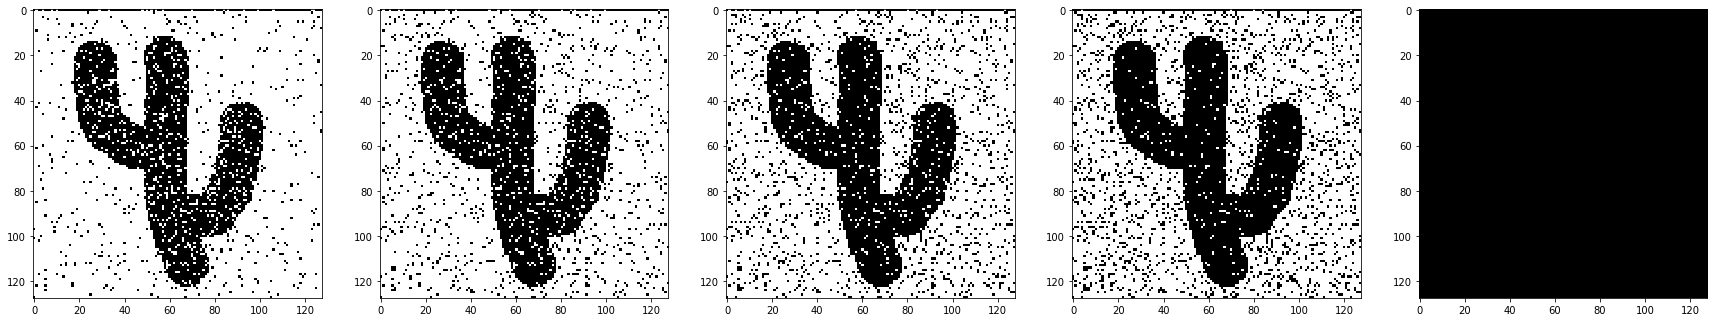

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image
import scipy.io

cact = np.array(Image.open('cactus.png'))
cact = cact.astype('float')/255

fig = plt.figure(figsize=(30,10))

for i in range(1,6):
    seg_cact = cact > i/5
    ax = fig.add_subplot(1,5,i)
    ax.imshow(seg_cact, cmap = 'gray')

# Image Relaxation

In [2]:
def relaximage(image, niters):
    # initialize confidence, delta, rij
    c = image
    d = 1
    rij = 0.25
    
    for _ in range(niters):
        s = np.zeros(c.shape)
        for i in range(1, len(c) - 1):
            for j in range(1, len(c[0]) - 1):
                s[i][j] = 0
                s[i][j] += rij * c[i+1][j] - rij * (1 - c[i+1][j])
                s[i][j] += rij * c[i][j+1] - rij * (1 - c[i][j+1])
                s[i][j] += rij * c[i-1][j] - rij * (1 - c[i-1][j])
                s[i][j] += rij * c[i][j-1] - rij * (1 - c[i][j-1]) 
                
        updated_c = np.zeros(c.shape)
        
        for i in range(1, len(c)):
            for j in range(1, len(c[0])):
                new = c[i][j] + d * s[i][j]
                updated_c[i][j] = min(max(new, 0), 1)
                
        c = updated_c
        
    return c

# load images
cact = np.array(Image.open('cactus.png'))
cact = cact.astype('float')/255

bump = np.array(Image.open('bump.png'))
bump = bump.astype('float')/255

parts = np.array(Image.open('parts.png'))
parts = parts.astype('float')/255

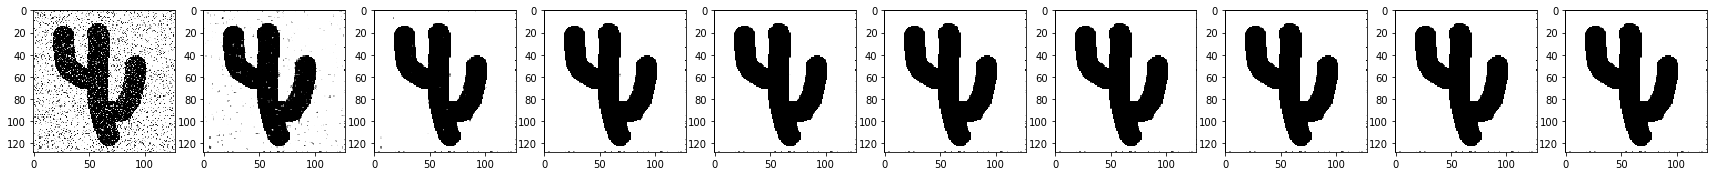

In [3]:
fig = plt.figure(figsize=(30,10))

# relax cactus

for i in range(1, 11):
    rel_cact = relaximage(cact, i - 1)
    ax = fig.add_subplot(1,10,i)
    ax.imshow(rel_cact, cmap = 'gray')

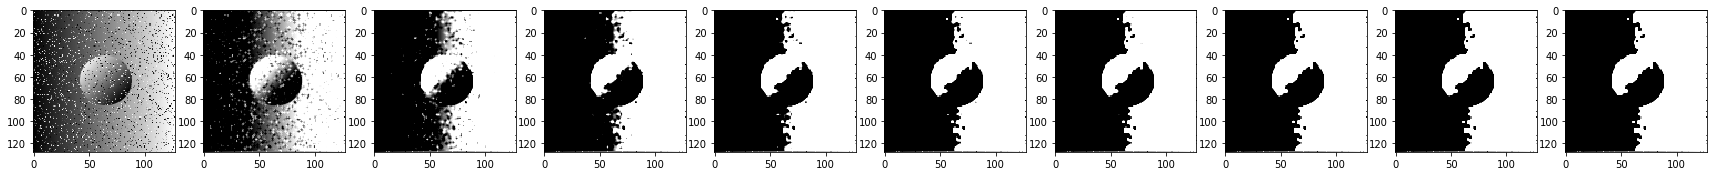

In [4]:
fig = plt.figure(figsize=(30,10))

# relax bump

for i in range(1, 11):
    rel_bump = relaximage(bump, i - 1)
    ax = fig.add_subplot(1,10,i)
    ax.imshow(rel_bump, cmap = 'gray')

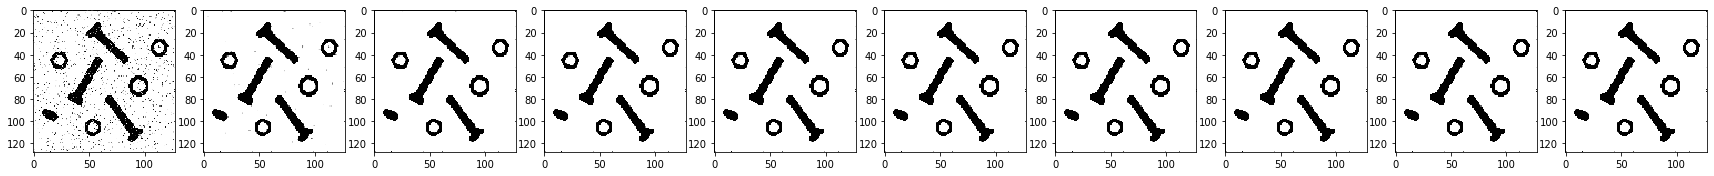

In [5]:
fig = plt.figure(figsize=(30,10))

# relax parts

for i in range(1, 11):
    rel_parts = relaximage(parts, i - 1)
    ax = fig.add_subplot(1,10,i)
    ax.imshow(rel_parts, cmap = 'gray')

# Disparity

In [8]:
def disparity(leftimg, rightimg, halfpatchsize, maxdisp=None):
    """DISPARITY Calculates the disparity for a pair of rectified stereo images.
    DISPMATRIX = DISPARITY(LEFTIMG, RIGHTIMG, HALFPATCHSIZE, MAXDISP) calculates
    the pointwise disparity between a pair of rectified stereo images.

    LEFTIMG is the left image of the stereo pair, while RIGHTIMG is the
    right image.

    HALFPATCHSIZE specifies half of the patch size (M in the problem
    statement in the homework). The patch size actually used ends up being
    2*HALFPATCHSIZE + 1.

    MAXDISP is an optional parameter specifying the maximum absolute
    disparity to be tested for. If omitted, it defaults to HALFPATCHSIZE.

    The output argument DISP should contain the disparity between the two
    images at every point where a valid patch comparison can be made. Note
    that, due to boundary effects, the size of DISPMATRIX will be smaller.
    """
    
    if maxdisp is None:
        maxdisp = halfpatchsize


    #get image dimensions
    nrows, ncols = leftimg.shape

    if nrows != rightimg.shape[0] or ncols != rightimg.shape[1]:
        raise ValueError("Left and right images aren't of the same size")


    #make sure you understand why the disparity matrix will be smaller than the input images!
    dispmatrix = np.zeros((np.array(leftimg.shape) - 2*halfpatchsize - np.array([0, 2*maxdisp])))

    #range of values for the central patch positions
    y0s = np.arange(halfpatchsize,(nrows - halfpatchsize))
    x0s = np.arange((halfpatchsize + maxdisp),(ncols - halfpatchsize - maxdisp))

    for j in range(len(x0s)):
        for i in range(len(y0s)):
            #get actual (x0,y0) position in the image
            x0 = x0s[j] #this is the horizontal index (col)
            y0 = y0s[i] #this is the vertical index (row)

            left = leftimg[y0 - halfpatchsize:y0 + halfpatchsize, x0 - halfpatchsize:x0+halfpatchsize]
            left_sum = left.sum(axis=1)
            norm_left = left / left_sum[:, np.newaxis]
            
            opt_sim = -1
            ind = -1
            
            for dx in range(-maxdisp, maxdisp):
                right = rightimg[y0 - halfpatchsize:y0 + halfpatchsize, x0 - halfpatchsize + dx:x0 + halfpatchsize + dx]
                right_sum = right.sum(axis=1)
                norm_right = right / right_sum[:, np.newaxis]
                
                sim = np.sum(norm_left * norm_right)

                if sim > opt_sim:
                    opt_sim = sim
                    ind = dx

            dispmatrix[i,j] = ind
            
    return dispmatrix

# load images
pent_left = np.array(Image.open('Pentagon-Left.tiff'))
pent_left = pent_left.astype('float')/255

pent_right = np.array(Image.open('Pentagon-Right.tiff'))
pent_right = pent_right.astype('float')/255

scene_left = np.array(Image.open('Scene-Left.tiff'))
scene_left = scene_left.astype('float')/255

scene_right = np.array(Image.open('Scene-Right.tiff'))
scene_right = scene_right.astype('float')/255

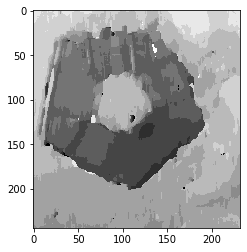

In [9]:
pent_disparity = disparity(pent_left, pent_right, 6)
plt.imshow(pent_disparity, cmap = 'gray')

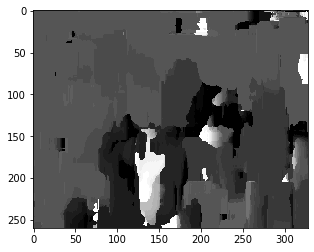

In [10]:
scene_disparity = disparity(scene_left, scene_right, 14)
plt.imshow(scene_disparity, cmap = 'gray')

# Perceptron

In [37]:
def perceptron_ans(train,trainlabel,step):
    #get dimensions of data matrix
    n = train.shape[0]
    d = train.shape[1]

    #appending the bias coefficient (1) to each data point
    train = np.concatenate([np.ones((n,1)), train],axis=1)
    
    w = np.random.permutation(d + 1).astype('float')

    rand_order = np.random.permutation(range(n))
    finished = False
    
    for _ in range(30):
        for ind in rand_order:
            res = np.dot(w, train[ind])

            if res > 0:
                res = 1
            else:
                res = -1

            if trainlabel[ind] * res < 0:
                w += step * trainlabel[ind] * train[ind]
            else:
                finished = True
           
        if finished:
            return w

    return w

# Training

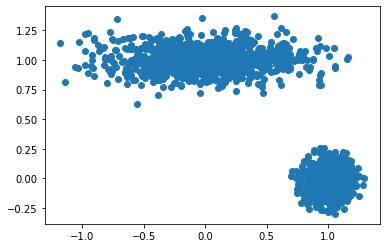

In [67]:
data0a = scipy.io.loadmat('Data0a.mat')
train = data0a['train']
trainlabel = data0a['trainlabel']

plt.plot(train[:, 0], train[:, 1], 'o')

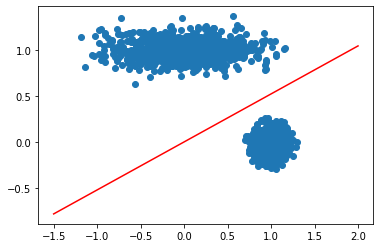

In [55]:
w = perceptron_ans(train, trainlabel, 1)
x = np.linspace(-1.5,2,50)
y = (-w[0] - w[1] * x)/w[2]

plt.plot(x,y,'-r')
plt.plot(train[:, 0], train[:, 1], 'o')

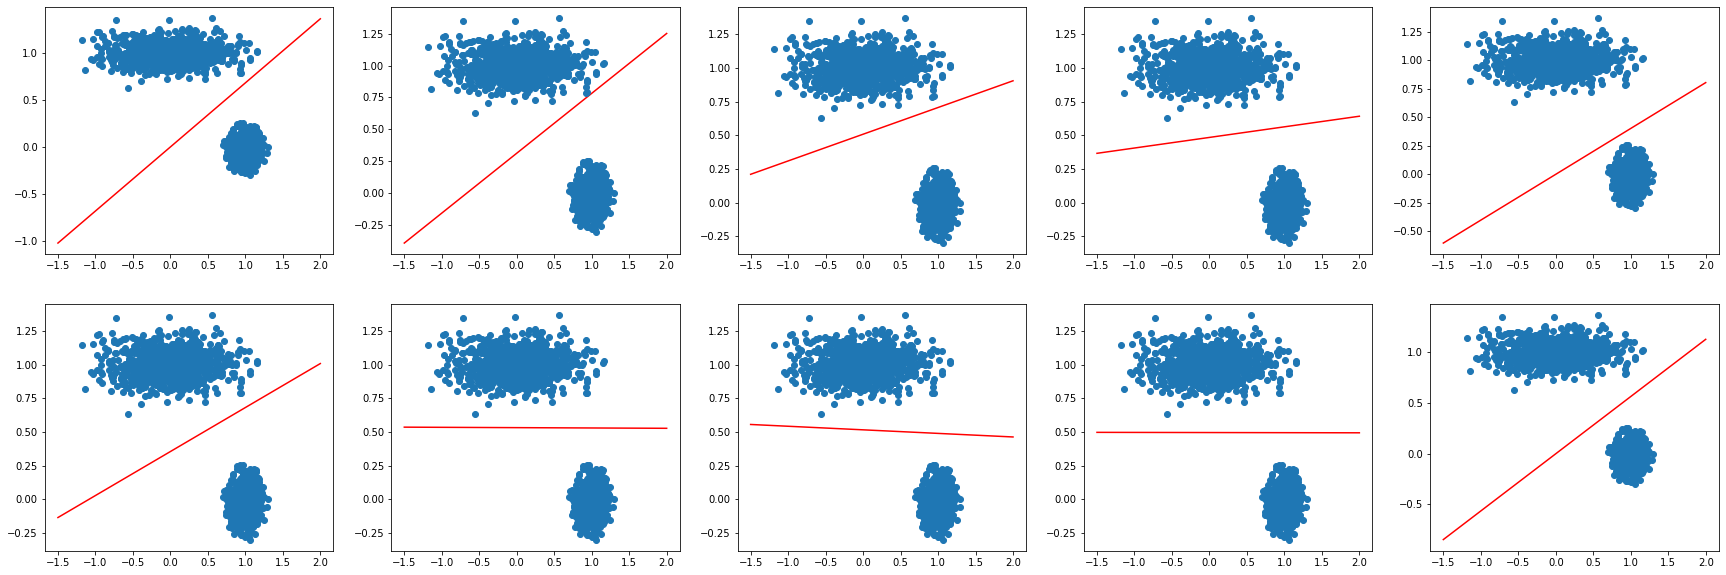

In [56]:
fig = plt.figure(figsize=(30,10))

for i in range(1, 11):
    w = perceptron_ans(train, trainlabel, 1)    
    x = np.linspace(-1.5,2,50)
    y = (-w[0] - w[1] * x)/w[2]
    
    ax = fig.add_subplot(2,5,i)
    ax.plot(x,y,'-r')
    ax.plot(train[:, 0], train[:, 1], 'o')

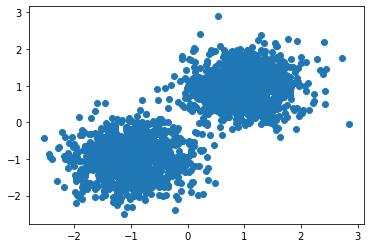

In [57]:
data0b = scipy.io.loadmat('Data0b.mat')
train = data0b['train']
trainlabel = data0b['trainlabel']

plt.plot(train[:, 0], train[:, 1], 'o')

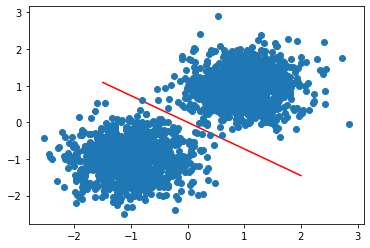

In [58]:
w = perceptron_ans(train, trainlabel, 1)
x = np.linspace(-1.5,2,50)
y = (-w[0] - w[1] * x)/w[2]

plt.plot(x,y,'-r')
plt.plot(train[:, 0], train[:, 1], 'o')

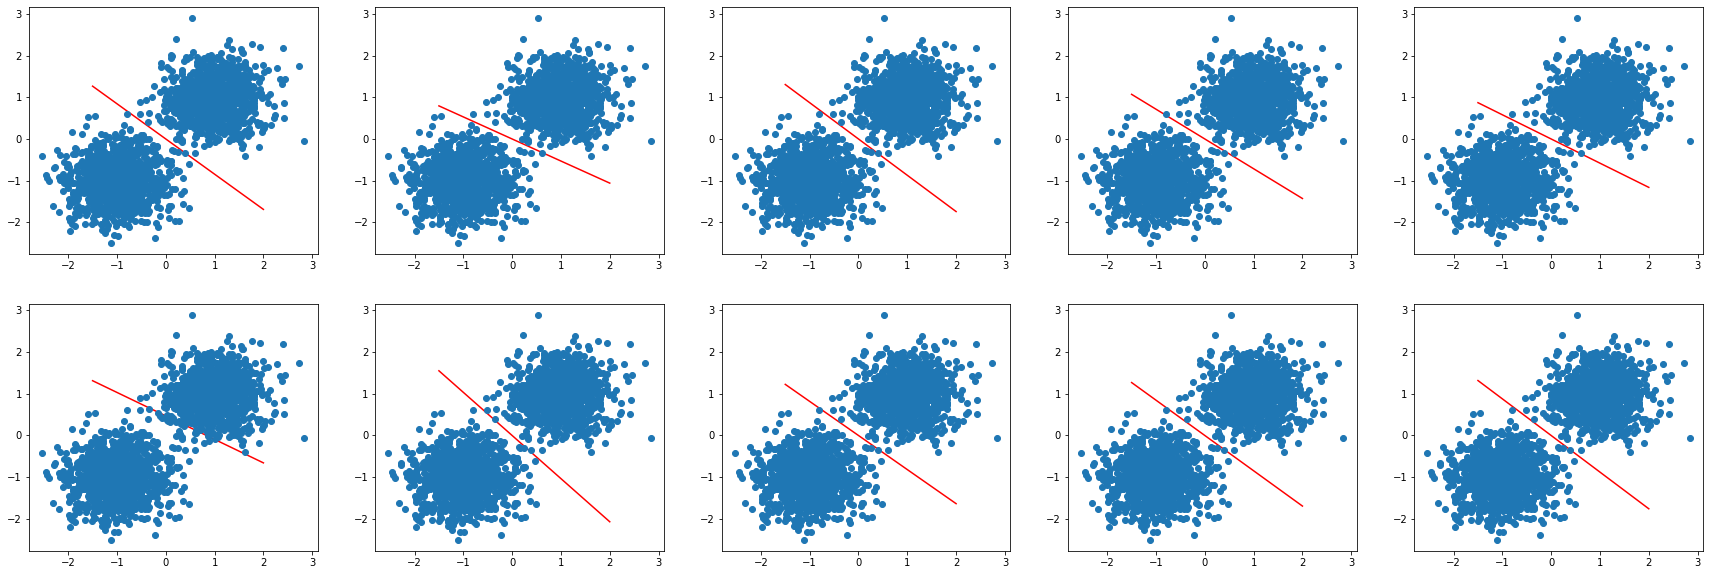

In [59]:
fig = plt.figure(figsize=(30, 10))

for i in range(1, 11):
    w = perceptron_ans(train, trainlabel, 1)    
    x = np.linspace(-1.5,2,50)
    y = (-w[0] - w[1] * x)/w[2]
    
    ax = fig.add_subplot(2,5,i)
    ax.plot(x,y,'-r')
    ax.plot(train[:, 0], train[:, 1], 'o')